In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv

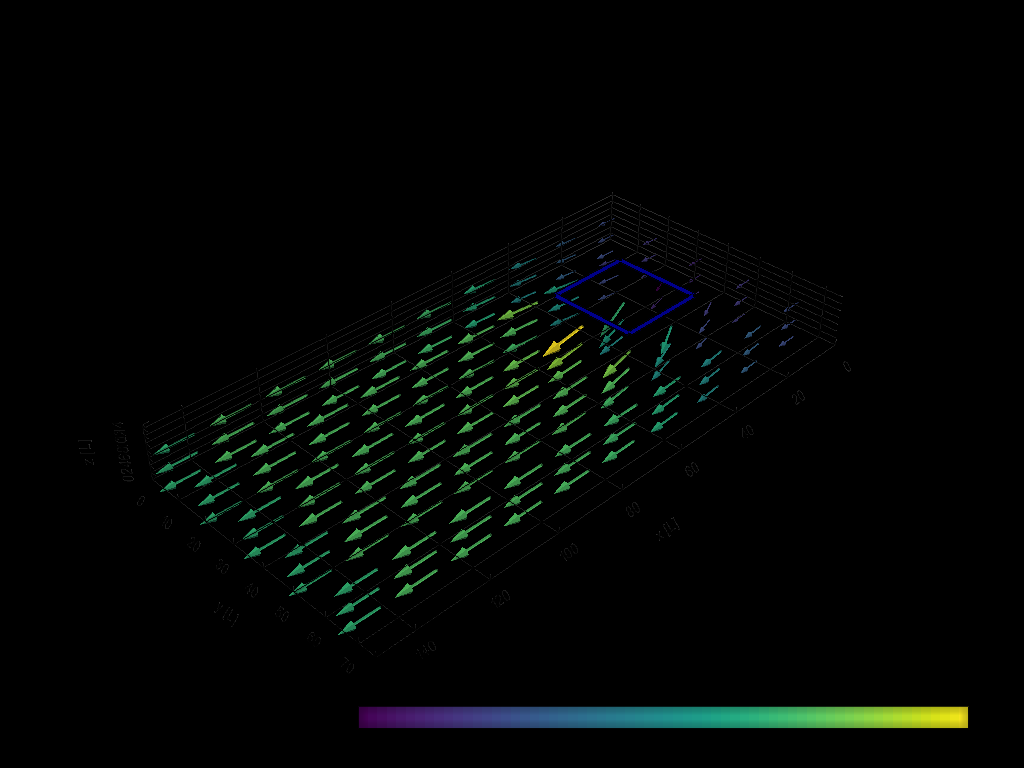

In [7]:
# user choice for cases
Case = 0 # 0 - homogeneous aquifer case ; 1 - heterogeneous aquifer case


if Case == 0:
    # homogeneous aquifer case
    f = open('aquifer_ho.ftl', 'r')
    factor = 10
else:
    # heterogeneous aquifer case
    f = open('aquifer_he.ftl', 'r')
    factor = 4
    
delx = 1
dely = 1
delz = 1

lambdax = 25
lambday = 25
lambdaz = 5

nlay = lambdaz*3
nrow = lambday*3
ncol = lambdax*6

cell_number = nlay * nrow * ncol
velocity_vector = np.zeros((cell_number,3))

for line in f:
    if line[3] == 'X':
        itera = 0
        for i in range(int(cell_number/3)):
            subline = f.readline().split()
            for j in range(3):
                velocity_vector[itera, 0] = float(subline[j])
                itera += 1

    if line[3] == 'Y':
        itera = 0
        for i in range(int(cell_number/3)):
            subline = f.readline().split()
            for j in range(3):
                velocity_vector[itera, 1] = float(subline[j])
                itera += 1

    if line[3] == 'Z':
        itera = 0
        for i in range(int(cell_number/3)):
            subline = f.readline().split()
            for j in range(3):
                velocity_vector[itera, 2] = float(subline[j])
                itera += 1
        
f.close()

vgrid = np.zeros((cell_number, 3))
iteration = 0
deltal = 1
for l in range(nlay):
    for k in range(nrow):
        for j in range(ncol):
            vgrid[iteration] = np.array(([j*deltal,k*deltal,l*deltal]))
            iteration += 1            
            
wellgrid = np.zeros((lambdax*lambday, 3))

deltal = 1
iteration = 0        
for l in range(lambdax, lambdax*2):
    for k in range(lambday, lambday*2):
        wellgrid[iteration] = np.array(([l*deltal,k*deltal,(nlay-1)*deltal]))
        iteration += 1
        
rawgrid = vgrid.reshape((15,75,150,3))
rawvelo = velocity_vector.reshape((15,75,150,3))
avgrid = np.zeros((3,5,10,3))
avvelo = np.zeros((3,5,10,3))
for i in range(10):
    for j in range(5):
        for k in range(3):
            avblock = rawgrid[5*k:(5*k+5),15*j:(15*j+15),15*i:(15*i+15)].reshape((15*15*5,3))
            avgrid[k,j,i] = [np.mean([avblock[i][0] for i in range(15*15*5)]),
                             np.mean([avblock[i][1] for i in range(15*15*5)]),
                             np.mean([avblock[i][2] for i in range(15*15*5)])]
            avblock = rawvelo[5*k:(5*k+5),15*j:(15*j+15),15*i:(15*i+15)].reshape((15*15*5,3))
            avvelo[k,j,i] = [np.mean([avblock[i][0] for i in range(15*15*5)]),
                             np.mean([avblock[i][1] for i in range(15*15*5)]),
                             np.mean([avblock[i][2] for i in range(15*15*5)])]
avgrid = avgrid.reshape((10*5*3, 3))
avvelo = avvelo.reshape((10*5*3, 3))        

point_cloud = pv.PolyData(avgrid)
point_cloud['vectors'] = avvelo

bounds = [0, 150, 0, 75, 0, 15]

arrows = point_cloud.glyph(orient='vectors', scale=True, factor=factor)

plotter = pv.Plotter()
sargs = dict(
    title_font_size=1,
    label_font_size=1,
    n_labels=5,
    fmt="%.1f",
    color ='k',
    font_family="arial",
)
plotter.add_mesh(arrows, scalars='GlyphScale', lighting=True, show_scalar_bar=True, stitle='Groundwater flow [L3/T]' , scalar_bar_args=sargs, opacity=0.8)
plotter.enable_eye_dome_lighting()

plotter.set_background('w')

welldata = pv.PolyData(wellgrid)
outline = welldata.outline()
plotter.add_mesh(outline, color="blue", line_width=6)

plotter.show_bounds(bounds=bounds, grid='back', location='outer', xlabel = 'x [L]', ylabel = 'y [L]', zlabel = 'z [L]', italic=True, font_family="arial",
                    font_size=12)
plotter.show()
# plotter.screenshot(filename='fig4.png', transparent_background=True)
